# Instance Circuits

Compute prune scores per instance, then using Thresholding algorithms (e.g. knee point),
compute per instance sparse circuits, and evaluate circuit performance. 

Learn circuit with sparsity of average of instance circuit sparsity using edge pruning, 
compare performance

In [102]:
from functools import partial
from collections import defaultdict
from typing import Dict
import math

import torch
import numpy as np

from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens

from elk_experiments.utils import repo_path_to_abs_path, set_model, repo_path_to_abs_path
from elk_experiments.auto_circuit_utils import make_prompt_data_loader, make_mixed_prompt_dataloader, sorted_scores
from elk_experiments.mask_gradient_instance import mask_gradient_instance_prune_scores

from auto_circuit.types import AblationType, BatchKey, PruneScores
from auto_circuit.data import PromptPairBatch   
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores

In [2]:
model_name = "pythia-70m"
device="cpu"
task_name="ifelse"
resid_pre=False 
resid_post=False 
attn=True 
mlp=False
ablation_type = AblationType.ZERO
abs_scores = True

In [3]:
from cupbearer import tasks
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 2048, 1024, 1024)
set_model(task.model, disbale_grad=True)
out_dir = repo_path_to_abs_path(f"output/{task_name}_{model_name}_resid_pre_{resid_pre}_resid_post_{resid_post}_attn_{attn}_mlp_{mlp}")
if not out_dir.exists():
    out_dir.mkdir(parents=True)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  cpu


In [4]:
from auto_circuit.utils.graph_utils import patchable_model
model = patchable_model(
    task.model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True,
    device=device,
    resid_src=resid_pre,
    resid_dest=resid_post,
    attn_src=attn,
    attn_dest=attn,
    mlp_src=mlp, 
    mlp_dest=mlp
)

In [5]:
batch_size = 32
effect_tokens = get_effect_tokens(task_name, task.model)
trainloader = make_prompt_data_loader(task.trusted_data, effect_tokens, task.model, batch_size)
testloader = make_prompt_data_loader(task.test_data.normal_data, effect_tokens, task.model, batch_size)

## Collect Prune Scores

In [6]:
prune_scores = mask_gradient_instance_prune_scores(
    model=model,
    dataloader=trainloader,
    official_edges=None,
    grad_function="logit",
    answer_function="avg_val",
    mask_val=0.0,
    ablation_type=ablation_type,
    clean_corrupt=None
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Knees

In [11]:
# prune scores flat in batch_dict
def flatten_instance_prune_scores(prune_scores: Dict[str, Dict[BatchKey, torch.Tensor]]) -> Dict[BatchKey, torch.Tensor]:
    batch_keys = next(iter(prune_scores.values())).keys()
    return {
        batch_key: torch.cat(
            [ps_mod[batch_key].flatten(start_dim=1) for ps_mod in prune_scores.values()], 
            dim=1
        ) 
        for batch_key in batch_keys
    }


In [12]:
prune_scores_flat = flatten_instance_prune_scores(prune_scores)

In [14]:
flat_prune_scores = flatten_instance_prune_scores(prune_scores)
flat_abs_prune_scores = {batch_key: torch.abs(prune_score) for batch_key, prune_score in flat_prune_scores.items()}
flat_sorted_prune_scores = {batch_key: torch.sort(prune_score, dim=1, descending=False).values for batch_key, prune_score in flat_abs_prune_scores.items()}
flat_sorted_prune_scores_all = torch.cat([prune_score for prune_score in flat_sorted_prune_scores.values()], dim=0)

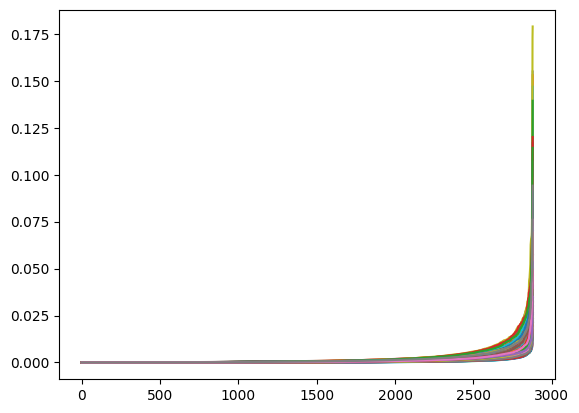

In [15]:
# plot the attribution scores for each instance
import matplotlib.pyplot as plt
for i in range(len(flat_sorted_prune_scores_all)):
    plt.plot(flat_sorted_prune_scores_all.cpu().numpy()[i])

In [21]:
# here we nedd all the prune scores flattened and sorted by batch 
# compute knees
from kneed import KneeLocator
knees_poly, knees_1d = defaultdict(list), defaultdict(list)
for batch_key, ps_batch in flat_sorted_prune_scores.items():
    for i in range(ps_batch.shape[0]):
        kneedle_poly = KneeLocator(
            np.arange(len(ps_batch[i])),
            ps_batch[i],
            S=1.0,
            curve="convex",
            direction="increasing",
            interp_method="polynomial"
        )
        knees_poly[batch_key].append(kneedle_poly.knee)
        kneedle_1d = KneeLocator(
            np.arange(len(ps_batch[i])),
            ps_batch[i],
            S=1.0,
            curve="convex",
            direction="increasing",
            interp_method="interp1d"
        )
        knees_1d[batch_key].append(kneedle_1d.knee)

In [22]:
knees_poly_all = [knee for knees in knees_poly.values() for knee in knees]
knees_1d_all = [knee for knees in knees_1d.values() for knee in knees]

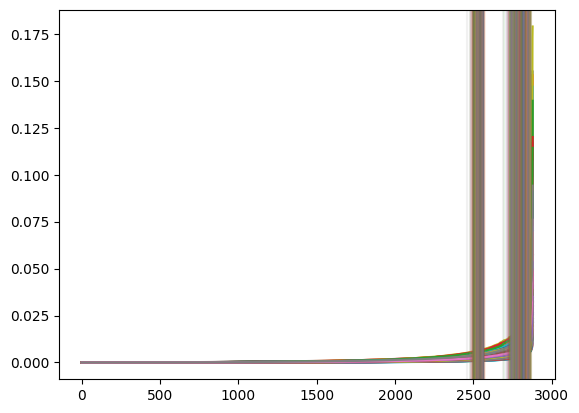

In [23]:
import matplotlib.colors as mcolors
# plot knees with different colors
for i in range(len(flat_sorted_prune_scores_all)):
    plt.plot(flat_sorted_prune_scores_all[i])
colors = list(mcolors.TABLEAU_COLORS.values())
for i, (knee_poly, knee_1d) in enumerate(zip(knees_poly_all, knees_1d_all)):
    color = colors[i % len(colors)] 
    plt.axvline(knee_poly, color=color, alpha=0.1)
    plt.axvline(knee_1d, color=color, alpha=0.1)

In [24]:
n_edges_poly = {batch_key: [model.n_edges - knee for knee in knees] for batch_key, knees in knees_poly.items()}
n_edges_1d = {batch_key: [model.n_edges - knee for knee in knees] for batch_key, knees in knees_1d.items()}
n_edges_poly_all = [model.n_edges - knee for knee in knees_poly_all]
n_edges_1d_all = [model.n_edges - knee for knee in knees_1d_all]
print("mean", np.mean(n_edges_poly_all), np.mean(n_edges_1d_all))
print("max", np.max(n_edges_poly_all), np.max(n_edges_1d_all))
print("min", np.min(n_edges_poly_all), np.min(n_edges_1d_all))
print("range", np.ptp(n_edges_poly_all), np.ptp(n_edges_1d_all)), 
print("median", np.median(n_edges_poly_all), np.median(n_edges_1d_all))

mean 343.80078125 75.576171875
max 422 190
min 305 11
range 117 179
median 343.0 74.0


## Run Instance Circuits with Instance Patch Masks For Different Knees

In [42]:
# descending prune scores (torch)
def desc_prune_scores_batch(prune_scores_batch: PruneScores) -> torch.Tensor:
   # prune_scores_batch: mod_name -> [batch, src, dest]
   prune_scores_flat = torch.cat([score.flatten(start_dim=1) for score in prune_scores_batch.values()], dim=1)
   prune_scores_sorted, _ = prune_scores_flat.abs().sort(dim=1, descending=True)
   return prune_scores_sorted

In [66]:
from typing import List
def prune_scores_threshold_batch(ps_batch_desc: torch.Tensor, n_edges: List[int]) -> torch.Tensor:
    assert len(n_edges) == ps_batch_desc.shape[0]
    gathered = torch.gather(ps_batch_desc, 1, torch.tensor(n_edges).unsqueeze(0)-1).squeeze(0)
    assert gathered.shape == (ps_batch_desc.shape[0],)
    return gathered

In [67]:
batch = next(iter(trainloader))
ps_batch = {mod_name: prune_scores[mod_name][batch.key] for mod_name in prune_scores.keys()}
ps_batch_desc = desc_prune_scores_batch(ps_batch)

In [68]:
threshold_batch = prune_scores_threshold_batch(ps_batch_desc, n_edges_1d[batch.key])

In [69]:
ps_batch_desc[0] > 0

tensor([True, True, True,  ..., True, True, True])

In [70]:
n_edges_1d[batch.key][:5]

[120, 55, 79, 64, 61]

In [71]:
ps_batch_desc[0][55]

tensor(0.0080)

In [72]:
(ps_batch_desc[0] > ps_batch_desc[0][120]).sum()

tensor(120)

In [73]:
ps_batch_desc.shape

torch.Size([32, 2880])

In [74]:
gathered = torch.gather(ps_batch_desc, 1, torch.tensor(n_edges_1d[batch.key]).unsqueeze(0)).squeeze(0)

In [75]:
gathered

tensor([0.0052, 0.0080, 0.0064, 0.0071, 0.0074, 0.0066, 0.0061, 0.0069, 0.0068,
        0.0080, 0.0052, 0.0080, 0.0066, 0.0056, 0.0096, 0.0083, 0.0094, 0.0080,
        0.0066, 0.0055, 0.0094, 0.0060, 0.0052, 0.0075, 0.0065, 0.0065, 0.0084,
        0.0124, 0.0068, 0.0094, 0.0059, 0.0086])

In [76]:
threshold_batch

tensor([0.0052, 0.0083, 0.0065, 0.0072, 0.0075, 0.0066, 0.0061, 0.0070, 0.0069,
        0.0080, 0.0052, 0.0080, 0.0066, 0.0056, 0.0097, 0.0084, 0.0094, 0.0083,
        0.0068, 0.0056, 0.0094, 0.0061, 0.0052, 0.0076, 0.0066, 0.0066, 0.0086,
        0.0126, 0.0069, 0.0094, 0.0060, 0.0086])

In [77]:
# TODO: check patch mask - ah right we don't necesserioly expect them to match, we just expect them to match in the end

In [78]:
from typing import Dict 
from tqdm import tqdm 
from auto_circuit.utils.ablation_activations import src_ablations
from auto_circuit.utils.graph_utils import patch_mode, set_mask_batch_size
from auto_circuit.utils.misc import module_by_name
from auto_circuit.utils.tensor_ops import desc_prune_scores, prune_scores_threshold
from auto_circuit.types import PatchType, BatchKey
from auto_circuit.utils.patch_wrapper import PatchWrapper
import torch as t

patch_type = PatchType.TREE_PATCH

circ_outs: Dict[str, Dict[BatchKey, torch.Tensor]] = {"inter1d": {}, "polynomial": {}}
n_edges = {"inter1d": n_edges_1d, "polynomial": n_edges_poly}
patch_edge_count = {thresh_name: 0 for thresh_name in n_edges.keys()}
with set_mask_batch_size(model, batch_size):
    for (thresh_name), n_edges_batch in (thresh_pbar := tqdm(n_edges.items())):
        thresh_pbar.set_description_str(f"Pruning Threshold {thresh_name}", refresh=True)
        for batch_idx, batch in enumerate(batch_pbar := tqdm(trainloader)):
            batch_pbar.set_description_str(f"Pruning Batch {batch_idx}", refresh=True)
            
            # get patch source outs
            patch_src_outs = src_ablations(model, batch.clean, AblationType.ZERO)

            assert patch_src_outs is not None
            # get descending scores for threshold calculation
            ps_batch = {mod_name: prune_scores[mod_name][batch.key] for mod_name in prune_scores.keys()}
            ps_batch_desc = desc_prune_scores_batch(ps_batch)
            
            with patch_mode(model, patch_src_outs):
                threshold_batch = prune_scores_threshold_batch(ps_batch_desc, n_edges_batch[batch.key]) #TODO: index by batch key
                # When prune_scores are tied we can't prune exactly edge_count edges
                for mod_name, patch_mask_dict in prune_scores.items():
                    patch_mask = patch_mask_dict[batch.key]
                    dest = module_by_name(model, mod_name)
                    assert isinstance(dest, PatchWrapper)
                    assert dest.is_dest and dest.patch_mask is not None
                    if patch_type == PatchType.EDGE_PATCH:
                        dest.patch_mask.data = (patch_mask.abs() >= threshold_batch).float() #TODO: debug
                        patch_edge_count[thresh_name] += dest.patch_mask.int().sum().item()
                    else:
                        assert patch_type == PatchType.TREE_PATCH
                        # if dest.patch_mask.data.shape != threshold_batch.shape: 
                        #print(f"dest.patch_mask.data.shape: {dest.patch_mask.data.shape}, threshold_batch.shape: {threshold_batch.shape}", "patch_mask.shape", patch_mask.shape)
                        dest.patch_mask.data = (patch_mask.abs() < threshold_batch.view(threshold_batch.size(0), 1, 1)).float() #TODO: debug
                        patch_edge_count[thresh_name] += (1 - dest.patch_mask.int()).sum().item()
                        #rint(dest.patch_mask.data.shape)
                        #assert model.n_edges * - sum(n_edges_batch[batch.key]) == model.n_edges - patch_edge_count[thresh_name], f"sum(n_edges_batch[batch.key]): {model.n_edges * 32 -sum(n_edges_batch[batch.key])}, patch_edge_count[thresh_name]: {patch_edge_count[thresh_name]}"
                with t.inference_mode(): 
                    model_output = model(batch.clean)[model.out_slice]
                circ_outs[thresh_name][batch.key] = model_output.detach().clone()
        del patch_src_outs

Pruning Threshold polynomial: 100%|██████████| 2/2 [00:42<00:00, 21.01s/it]


In [83]:
patch_edge_count["inter1d"] / 2048

81.59326171875

In [85]:
from elk_experiments.auto_circuit_utils import measure_kl_div

In [87]:
circ_outs.keys()

dict_keys(['inter1d', 'polynomial'])

In [89]:
kl_divs = measure_kl_div(model, trainloader,  circ_outs, over_vals=True)

In [97]:
model_outs: Dict[BatchKey, torch.Tensor] = {}
with torch.inference_mode():
    for batch_idx, batch in enumerate(tqdm(trainloader)):
        model_outs[batch.key] = model(batch.clean)[model.out_slice].detach().clone()

100%|██████████| 64/64 [00:09<00:00,  7.00it/s]


In [99]:
model_out_tensor = torch.cat([model_outs[batch.key] for batch in trainloader], dim=0)
model_out_probs = torch.nn.functional.softmax(model_out_tensor, dim=1)
acc = torch.sum(model_out_probs.argmax(dim=1) == answer).item() / len(model_out_tensor)
acc

0.2353515625

In [96]:
answer = next(iter(trainloader)).answers[0]
answer

for thresh_name, circ_out in circ_outs.items():
    circ_out_tensor = torch.concat(list(circ_out.values()), dim=0)
    circ_out_probs = torch.nn.functional.softmax(circ_out_tensor, dim=1)
    acc = torch.sum(circ_out_tensor.argmax(dim=1) == answer) / len(circ_out_tensor)
    mean_prob = torch.mean(circ_out_probs[torch.arange(len(circ_out_tensor)), answer])
    print(f"{thresh_name}: Accuracy: {acc}")
    print(f"{thresh_name}: Mean Prob: {mean_prob}")




inter1d: Accuracy: 0.0029296875
inter1d: Mean Prob: 0.0014886081917211413
polynomial: Accuracy: 0.0048828125
polynomial: Mean Prob: 0.0037850565277040005


In [95]:
circ_out_tensor.shape

torch.Size([2048, 50304])

## Box and Wiskers for All Knee Types, KL and Sparcity 

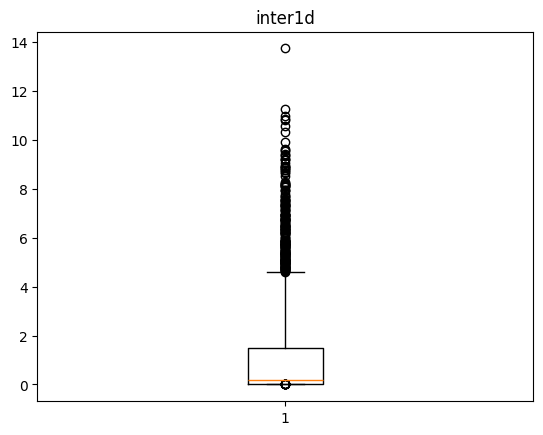

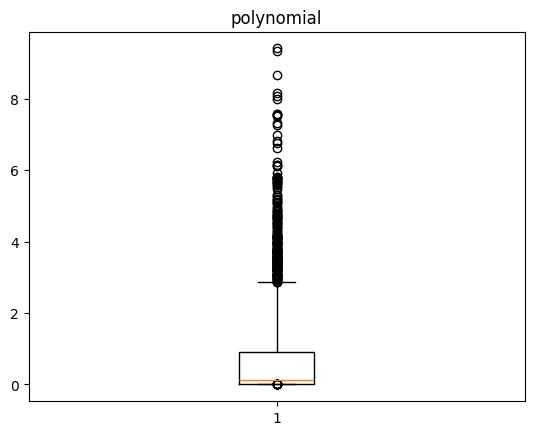

In [118]:
# box and wiskers plot 
import matplotlib.pyplot as plt
for thresh_name, _kl_div_mean, kl_divs_all in kl_divs:
    plt.boxplot(kl_divs_all, whis=(0.5, 90))
    plt.title(thresh_name)
    plt.show()
# _kl_div_mean, kl_divs_all = kl_divs[1:]
# plt.boxplot(kl_divs_all, whis=(0.5, 99.5))

## Compute Aggregate Circuit, Compare

In [105]:
patch_edge_count['polynomial'] / 2048

345.65771484375

In [107]:
for thresh_name, edge_count in patch_edge_count.items():
    print(f"{thresh_name}: {math.ceil(edge_count / 2048)}")

inter1d: 82
polynomial: 346


In [109]:
from auto_circuit.prune import run_circuits
# mean over gradients to get aggegrate prune scores
prune_scores_mean = {mod_name: torch.mean(torch.concat(list(prune_score.values()), dim=0), dim=0) for mod_name, prune_score in prune_scores.items()}

# use mean prune scores to run circuit with rounded mean sparity 
n_edges = [math.ceil(edge_count / 2048) for edge_count in patch_edge_count.values()]

circ_outs_mean = run_circuits(
    model=model,
    dataloader=trainloader,
    test_edge_counts=n_edges,
    prune_scores=prune_scores_mean,
    ablation_type=ablation_type,
    patch_type=PatchType.TREE_PATCH,
)

In [113]:
circ_outs_mean = circ_out_mean

In [110]:
kl_divs_mean = measure_kl_div(model, trainloader, circ_out_mean, over_vals=True)

In [114]:
for thresh_name, circ_out in circ_outs_mean.items():
    circ_out_tensor = torch.concat(list(circ_out.values()), dim=0)
    circ_out_probs = torch.nn.functional.softmax(circ_out_tensor, dim=1)
    acc = torch.sum(circ_out_tensor.argmax(dim=1) == answer) / len(circ_out_tensor)
    mean_prob = torch.mean(circ_out_probs[torch.arange(len(circ_out_tensor)), answer])
    print(f"{thresh_name}: Accuracy: {acc}")
    print(f"{thresh_name}: Mean Prob: {mean_prob}")

82: Accuracy: 0.01171875
82: Mean Prob: 0.005164934787899256
346: Accuracy: 0.01025390625
346: Mean Prob: 0.005451533943414688


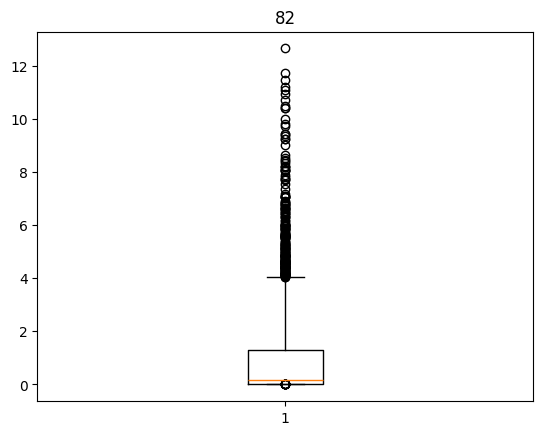

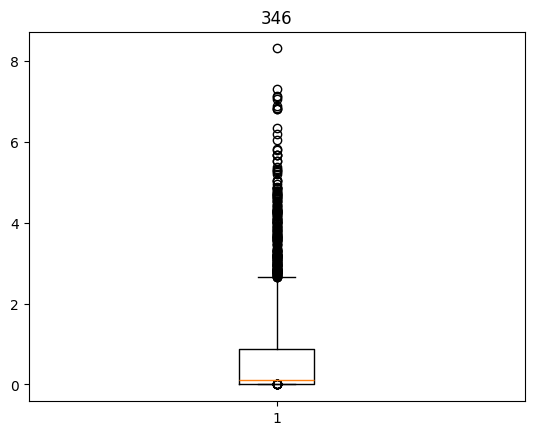

In [117]:
import matplotlib.pyplot as plt
for thresh_name, _kl_div_mean, kl_divs_all in kl_divs_mean:
    plt.boxplot(kl_divs_all, whis=(0.5, 90))
    plt.title(thresh_name)
    plt.show()

In [123]:
for i in range(len(kl_divs)):
    thresh_name = kl_divs[i][0]
    kl_divs_all = kl_divs[i][2]
    kl_divs_mean_all = kl_divs_mean[i][2]
    print("thresh_name", thresh_name)
    print("mean", np.mean(kl_divs_mean_all), np.mean(kl_divs_all))
    print("std", np.std(kl_divs_mean_all), np.std(kl_divs_all))
    print("max", np.max(kl_divs_mean_all), np.max(kl_divs_all))
    print("min", np.min(kl_divs_mean_all), np.min(kl_divs_all))
    print("range", np.ptp(kl_divs_mean_all), np.ptp(kl_divs_all))
    print("median", np.median(kl_divs_mean_all), np.median(kl_divs_all))

thresh_name inter1d
mean 1.1328862354746299 1.2572527267531926
std 1.9413395215708182 2.1085655352736343
max 12.644675254821777 13.734504699707031
min 0.0 0.0
range 12.644675254821777 13.734504699707031
median 0.1664411574602127 0.18352358788251877
thresh_name polynomial
mean 0.7444080748110774 0.8089488332838024
std 1.2735034312973001 1.4007915662806325
max 8.30131721496582 9.402682304382324
min 0.0 0.0
range 8.30131721496582 9.402682304382324
median 0.10230905562639236 0.11599930375814438


In [ ]:
# not sure If I'm implementing this right, also want to try 
# a. not including negative edges
# b. using mean ablation

In [ ]:
# ok I'm not sure what to do with this
# one thing would be to investigate the anomalous examples - whether they have a higher or lawer edge count, and whether they are similar across batches 
# if the anomalous examples tend to have smaller edge counts, then we could set them to the mean, and then compute the new mean
# eh, I guess its still a decently intererestign result - you get compareable performance when thresholding instances 
# TODO: I guess natural next step is to evaluate different faitfulness metrics - accuracy, logit difference
# the other thing would be to compare to random pruning, say with the same mean and std

## Learn Edge Mask with Same Sparsity for each Edge Type

## Box and Wiskers on KL for Both